# 1. Thresholding Technique

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### A. Simple Thresholding

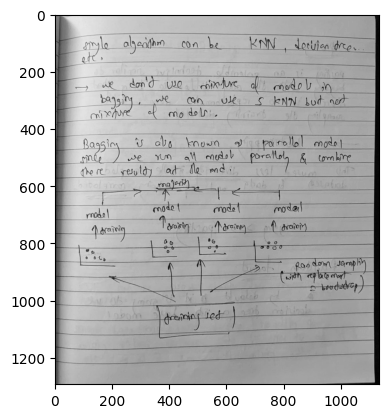

In [6]:
image_gray = cv2.imread("../images/handwritten.jpeg",0)
plt.imshow(image_gray,cmap="gray")

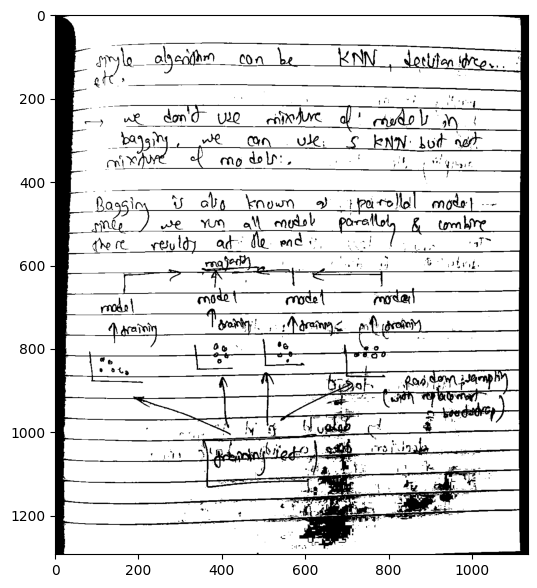

In [ ]:

retval, binary = cv2.threshold(image_gray,150,255,cv2.THRESH_BINARY)

plt.figure(figsize=(12,7))

plt.imshow(binary,cmap="gray")

### B. Adaptive Thresholding

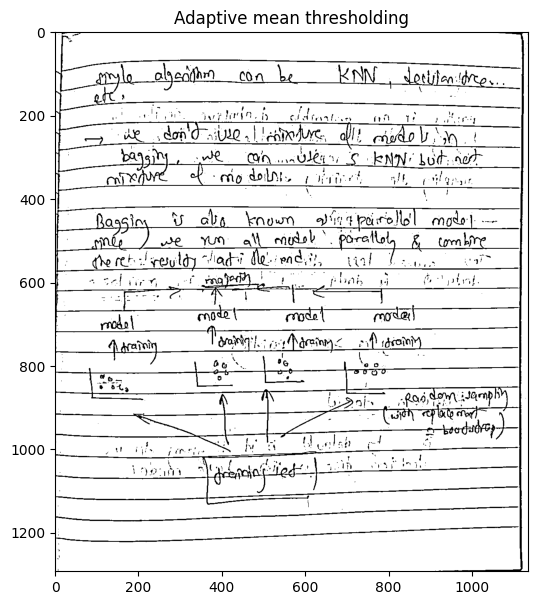

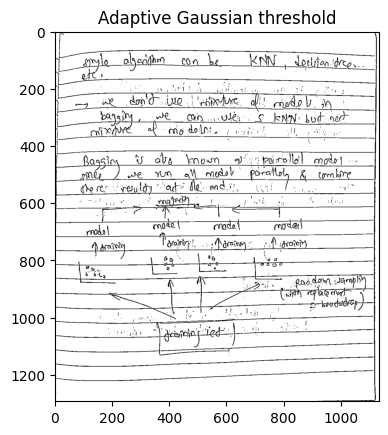

In [ ]:
adaptive_m = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,9) # try various c values 8 or 12 or 15 and see difference

adaptive_g = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,9)


plt.figure(figsize=(12,7))

plt.imshow(adaptive_m,cmap="gray")
plt.title("Adaptive mean thresholding")
plt.show()

plt.imshow(adaptive_g,cmap="gray")
plt.title("Adaptive Gaussian threshold")
plt.show()

# 2. K-Means Clutering Technique

[[255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]
 ...
 [255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]]
391876


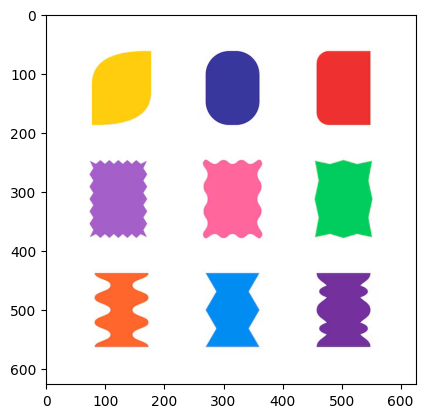

In [ ]:
image = cv2.imread("../images/shapes.jpg")
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

pixel_values = image_rgb.reshape((-1,3)) # flattening image with RGB shape
pixel_values = np.float32(pixel_values)
print(pixel_values)
print(len(pixel_values))

In [25]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3

_, labels, centers = cv2.kmeans(pixel_values,k, None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)



In [26]:
print(labels.shape)
print(centers)

(391876, 1)
[[ 70.9147   110.96521  167.68669 ]
 [255.2777   255.2192   255.20657 ]
 [249.43346  114.88152   69.147255]]


In [29]:
labels.flatten()

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'segmented Image')

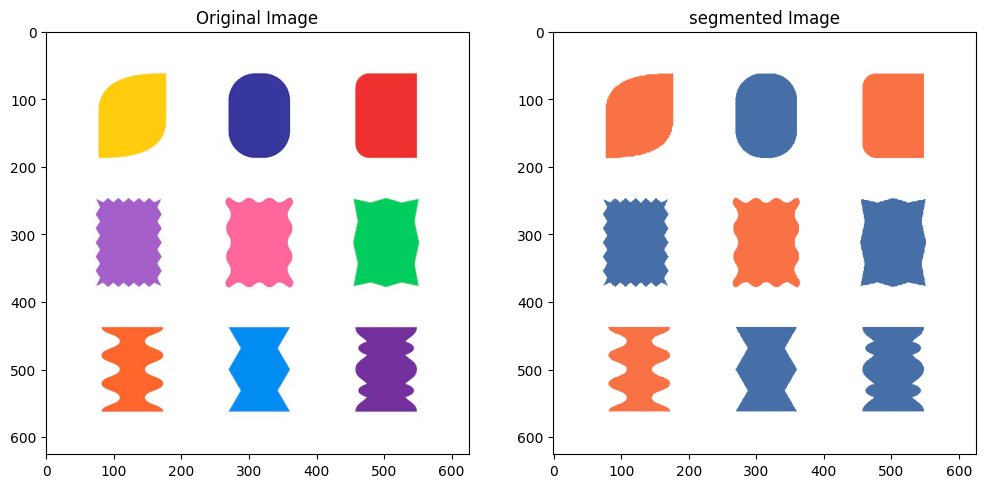

In [36]:
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(image_rgb.shape)

# 0 -> [70,110,167]
# 1 -> [255,255,255]
# 2 -> [249,114,69]

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("segmented Image")

# output we can see only 2 classify categories orange and blue, but 3rd one is whole image itself.

# 3. Watershed Algorithm

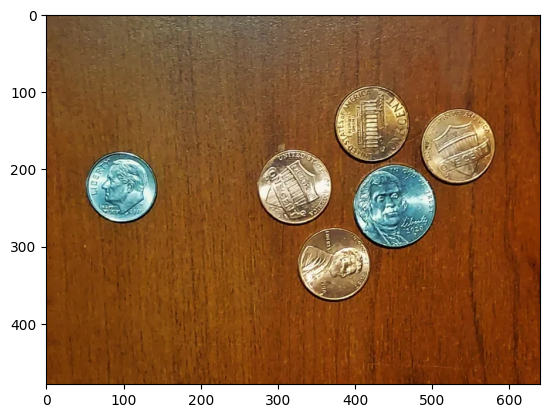

In [41]:
image = cv2.imread("../images/coin2.jpg")

image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
original_image = image_rgb.copy()
plt.imshow(original_image)

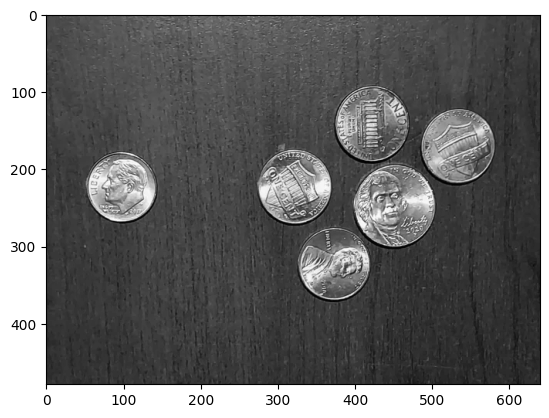

In [ ]:
# convert into gray
gray = cv2.cvtColor(original_image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

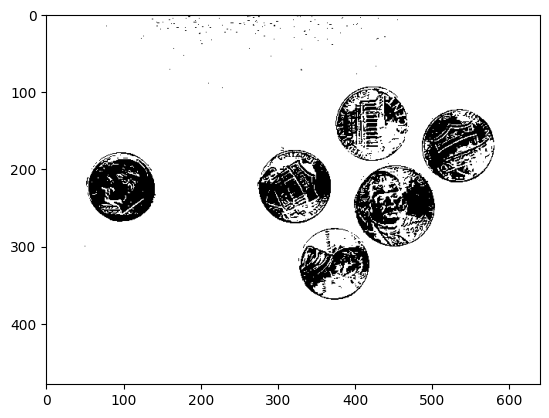

In [ ]:
# Apply thresholdng
_, thresh = cv2.threshold(gray,130,255,cv2.THRESH_BINARY_INV)

plt.imshow(thresh,cmap="gray")

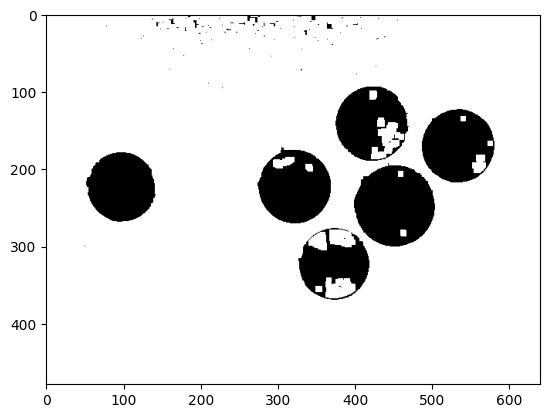

In [47]:
# Remove Noise

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel,iterations=3)

plt.imshow(opening,cmap="gray")

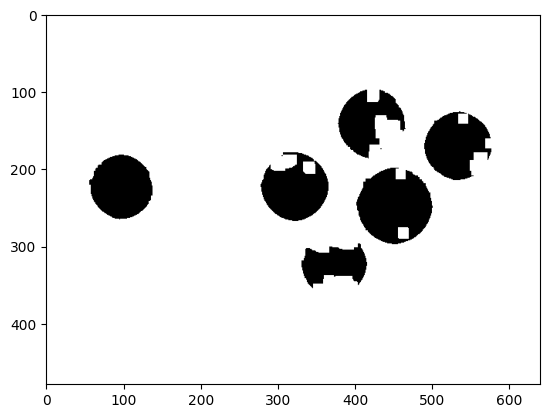

In [48]:
sure_bg = cv2.dilate(opening,kernel,iterations=3) # sure background
plt.imshow(sure_bg,cmap="gray")

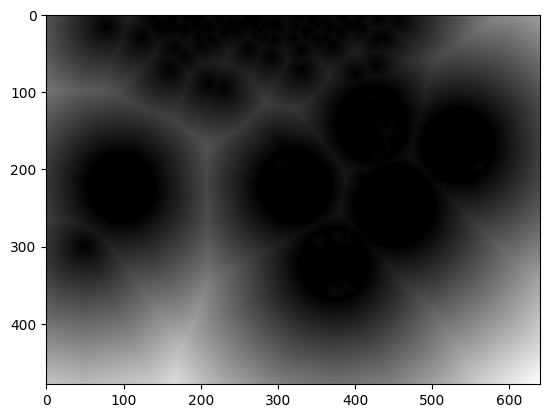

In [49]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

plt.imshow(dist_transform,cmap="gray")

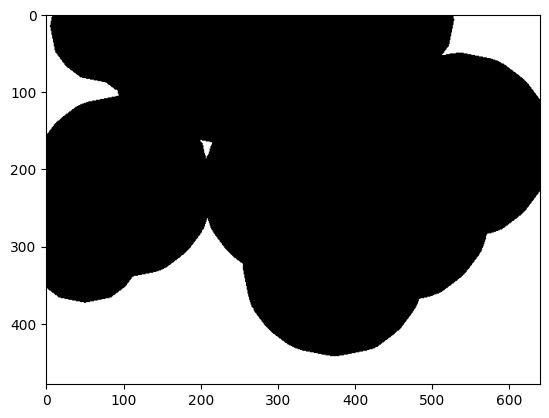

In [58]:
_, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg,cmap="gray")

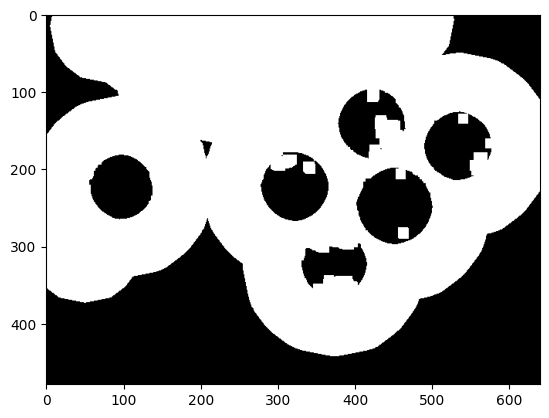

In [60]:
unknown_region = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown_region,cmap="gray")

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]]


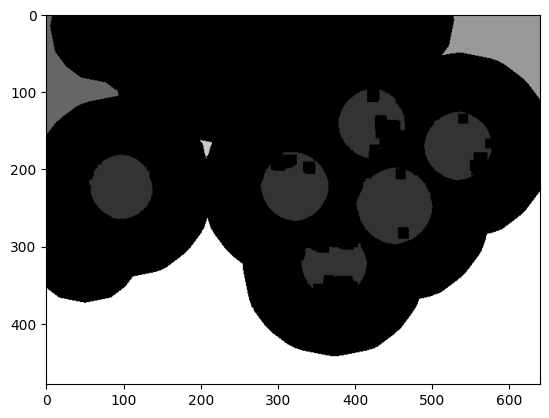

In [ ]:
_ , markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown_region == 255] = 0

plt.imshow(markers,cmap="gray")

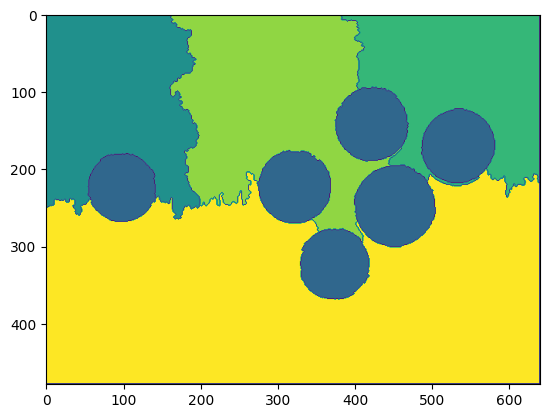

In [85]:
markers = cv2.watershed(image,markers)
plt.imshow(markers)

In [88]:
coin_mask = np.zeros_like(gray)

print(gray.shape)
print(coin_mask.shape)

unique_labels = np.unique(markers)

insatnce_number = 1
font = cv2.FONT_HERSHEY_SIMPLEX

for label in unique_labels:
    if label == 0 or label == -1:
        continue
    
    mask = np.uint8(markers == label)
    contours , _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour,True)

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimeter * perimeter))

        if 0.7 < circularity < 1.2 and area > 1000:
            cv2.drawContours(original_image,[contour],-1,(0,255,0),2)
            x,y,w,h = cv2.boundingRect(contour)
            cv2.putText(original_image,f"Coin {insatnce_number}",(x,y-10),font,0.6,(255,0,0),2)
            coin_mask = cv2.bitwise_or(coin_mask,mask)
            cv2.rectangle(original_image,(x-5,y-5),(x+w+5,y+h+5),(160,150,250),2)
            insatnce_number +=  1


(479, 640)
(479, 640)


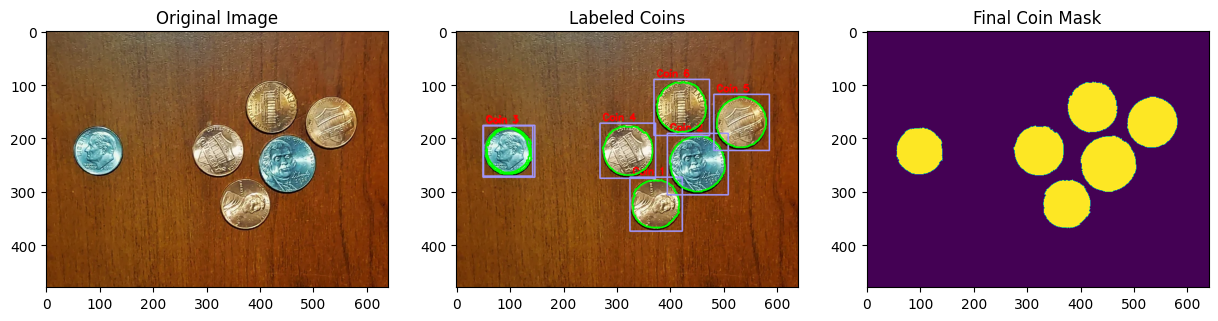

In [89]:
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(image_rgb)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(original_image)
plt.title("Labeled Coins")


plt.subplot(1,3,3)
plt.imshow(coin_mask)
plt.title("Final Coin Mask")

plt.show()